# Scenario A - Noise Level Variation

In this scenario the noise level on a generated dataset is varied in three steps: low/medium/high, 
the rest of the parameters in the dataset is kept constant.

The model used in the inference of the parameters is formulated as follows: 

\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}\big] + \epsilon
\end{equation}

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

#az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


## Import local modules

In [2]:
import datetime
import os
import sys
sys.path.append('../../modules')
import datagen as dg
import models as mdl
import results as res
import figures as fig
import settings as cnf

## Local configuration

In [3]:
# output for results and images
out_path      = './output_adapt_diag'
file_basename = out_path + '/scenario_noise'
        
# if dir does not exist, create it
if not os.path.exists(out_path):
    os.makedirs(out_path)

conf = {}
    
# scenario name
conf['scenario'] = 'noise variation'
    
# initialization method for sampler ('jitter+adapt_diag'/'advi+adapt_diag'/'adapt_diag')
conf['init_mode'] = 'adapt_diag'

# probabilistic model (priors)
conf['prior_model'] = 'lognormal'

# provide peak positions to the model as testvalues ('yes'/'no')
conf['peak_info'] = 'yes'

# absolute peak shift (e.g. 2%(4), 5%(10) or 10%(20) of X-min.)
conf['peak_shift'] = 0

# model mode ('train'/eval')
conf['model_mode'] = 'train'

# data mode ('generate'/'preload')
conf['data_mode'] = 'preload'

# dataset directory
conf['dataset_dir'] = './input_datasets'

# number of cores to run sampling chains on
conf['ncores'] = 2

# number of samples per chain
conf['nsamples'] = 2000

In [4]:
conf

{'scenario': 'noise variation',
 'init_mode': 'adapt_diag',
 'prior_model': 'lognormal',
 'peak_info': 'yes',
 'peak_shift': 0,
 'model_mode': 'train',
 'data_mode': 'preload',
 'dataset_dir': './input_datasets',
 'ncores': 2,
 'nsamples': 2000}

## Save configuration

In [5]:
cnf.save(out_path, conf)

# Generate data and plot

In [6]:
# list of wavelengths (x-values)
xval = [i for i in range(200, 400, 2)]

ldata  = []
lpeaks = []
lnoise = []

# number of spectra per noise level
nsets  = 10

# noise level is 1%, 2% and 5% of the minimal signal amplitude
noise_levels = [0.05, 0.10, 0.25]

# total number of datasets
tsets = nsets * len(noise_levels)

# real noise level list
for nl in noise_levels:
    for i in range(nsets):
        lnoise.append(nl)
        
if conf['model_mode'] == 'train' and conf['data_mode'] == 'generate':
    # generate the datasets
    for nl in noise_levels:
        for i in range(nsets):
            df, peaks, _ = dg.data_generator(xvalues=xval, nsamples=15, noise=nl)
            ldata.append(df)
            lpeaks.append(peaks)
    # save data to disk
    for i in range(len(ldata)):
        ldata[i].to_csv(out_path + '/dataset_%02d.csv' % (i+1), index=False)
    dg.data_save(out_path + '/peakinfo.csv', lpeaks)
        
elif conf['model_mode'] == 'train' and conf['data_mode'] == 'preload':           
    # load pre-generated datasets from disk
    ldata, lpeaks = dg.data_load(tsets, conf['dataset_dir'])
    
else:        
    # load data from disk
    if conf['data_mode'] == 'preload':
        ldata, lpeaks = dg.data_load(tsets, conf['dataset_dir'])
    else:
        ldata, lpeaks = dg.data_load(tsets, out_path)
        
# add peakshift
lpeaks = dg.add_peakshift(lpeaks, conf['peak_shift'])

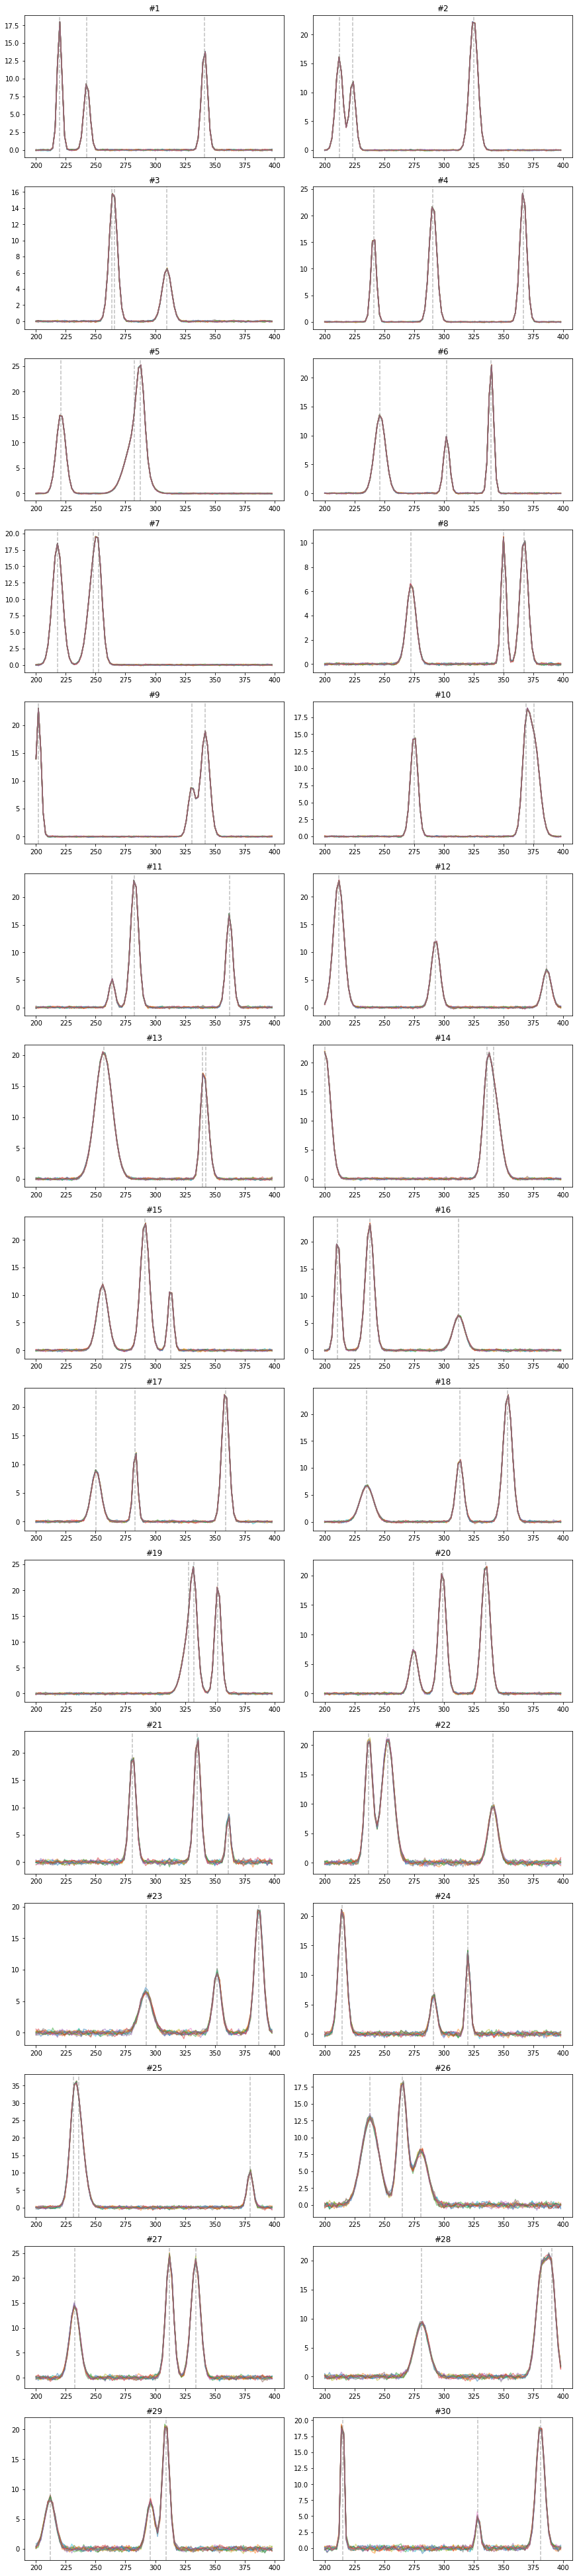

In [8]:
# plot datasets
fig.plot_datasets(ldata, lpeaks, dims=(int(tsets/2),2), figure_size=(12,int(tsets*(1.8))), 
                                                    savefig='yes', fname=file_basename)

# Initialize models and run inference

In [9]:
# convert pandas data to numpy arrays
x_val = np.array(xval, dtype='float32')

# store dataset y-values in list
cols = ldata[0].columns
y_val = [ldata[i][cols].values for i in range(len(ldata))]

In [10]:
# initialize models and run inference
models = []
traces = []

for i in range(len(ldata)):
    if conf['peak_info'] == 'yes':
        plist = lpeaks[i].flatten()
        plist.sort()
        model_g = mdl.model_gauss(xvalues=x_val, observations=y_val[i], npeaks=3, 
                                  mu_peaks=plist, pmodel=conf['prior_model'])
    else:
        model_g = mdl.model_gauss(xvalues=x_val, observations=y_val[i], npeaks=3,
                                  pmodel=conf['prior_model'])      
    models.append(model_g)
    
    with model_g:
        if conf['model_mode'] == 'train':
            print("running inference on dataset #{0}/{1}".format(i+1,len(ldata)))
            trace_g = pm.sample(conf['nsamples'], init=conf['init_mode'], cores=conf['ncores'])
            traces.append(trace_g)
            # save inference results
            pm.backends.text.dump(out_path + '/traces_%02d' % (i+1), trace_g)
        else:
            # load traces from disk
            print("loading dataset #{0}/{1}".format(i+1,len(ldata)))
            trace_g = pm.backends.text.load(out_path + '/traces_%02d' % (i+1))
            traces.append(trace_g)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #1/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:10<00:00, 486.72draws/s]
The acceptance probability does not match the target. It is 0.8897986334347165, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #2/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:09<00:00, 515.49draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8786365591262683, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #3/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1,246 divergences: 100%|██████████| 5000/5000 [03:46<00:00, 22.06draws/s] 
There were 985 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.14533630369192485, but should be close to 0.8. Try to increase the number of tuning steps.
There were 261 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #4/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 4 divergences: 100%|██████████| 5000/5000 [00:09<00:00, 518.59draws/s]
The acceptance probability does not match the target. It is 0.8997518525315771, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #5/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:22<00:00, 225.24draws/s]
The acceptance probability does not match the target. It is 0.9155852223491167, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.927675906227274, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #6/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 4 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 428.49draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8875926060528402, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9118575403510707, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #7/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:07<00:00, 73.63draws/s]
The acceptance probability does not match the target. It is 0.8807845306411376, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8951411339424376, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #8/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 10 divergences: 100%|██████████| 5000/5000 [00:09<00:00, 548.39draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8964029194420524, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #9/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:10<00:00, 473.19draws/s]
The acceptance probability does not match the target. It is 0.8944065526226118, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9216022444476095, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #10/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:36<00:00, 136.85draws/s]
The acceptance probability does not match the target. It is 0.8984300627219624, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8964257738272768, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #11/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:10<00:00, 467.98draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #12/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 10 divergences: 100%|██████████| 5000/5000 [00:08<00:00, 562.42draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #13/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:09<00:00, 71.63draws/s]
The acceptance probability does not match the target. It is 0.8895632767066989, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #14/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:44<00:00, 111.36draws/s]
The acceptance probability does not match the target. It is 0.8913464770487531, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #15/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:09<00:00, 504.96draws/s]
The acceptance probability does not match the target. It is 0.8834752777958256, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9109820761474079, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #16/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:09<00:00, 524.66draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8880171235220676, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #17/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:10<00:00, 480.36draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #18/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 402.43draws/s]
The acceptance probability does not match the target. It is 0.8833668202161599, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8820353681977562, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #19/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:24<00:00, 203.26draws/s]
The acceptance probability does not match the target. It is 0.9111200638620425, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #20/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:09<00:00, 547.19draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8861187246104102, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #21/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:08<00:00, 588.39draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #22/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:09<00:00, 516.95draws/s]
The acceptance probability does not match the target. It is 0.8820540194874736, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #23/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:09<00:00, 527.32draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #24/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:10<00:00, 488.74draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #25/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [02:49<00:00, 29.47draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #26/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:09<00:00, 516.19draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #27/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:08<00:00, 575.13draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #28/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:20<00:00, 248.47draws/s]
The acceptance probability does not match the target. It is 0.88783447787509, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #29/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:08<00:00, 586.45draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #30/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 443.19draws/s]


# Model visualization

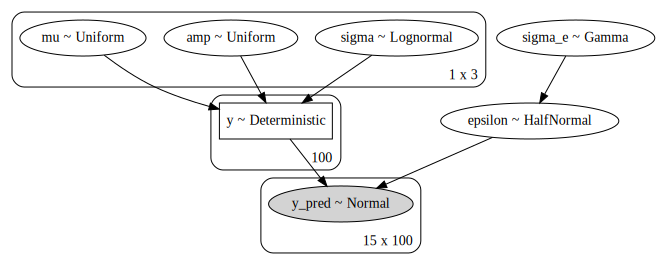

In [11]:
pm.model_to_graphviz(models[0])

In [12]:
# save model figure as image
img = pm.model_to_graphviz(models[0])
img.render(filename=file_basename + '_model', format='png');

# Collect results and save

In [13]:
# posterior predictive traces
ppc = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(traces))]

/home/ppsda/venv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 587.44it/s]
/home/ppsda/venv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 590.25it/s]


In [14]:
# various plots to inspect the inference results
varnames = ['amp', 'mu', 'sigma', 'epsilon']

#az.plot_trace(traces[2], varnames, compact=True);
#az.plot_trace(traces[2], varnames, divergences='top');
#az.plot_autocorr(traces[0], varnames);
#az.plot_posterior(traces[2], varnames);

#for idx, trace in enumerate(traces):
#    az.plot_forest(trace, var_names = varnames, r_hat=True, ess=True);

In [15]:
if conf['model_mode'] == 'train':
    # collect the results and display
    df = res.get_results_summary(varnames, traces, ppc, y_val, epsilon_real=lnoise)
else:
    # load results from disk
    df = pd.read_csv(file_basename + '.csv')
    df.index += 1
#df.sort_values(by=['r2'])
df

/home/ppsda/venv/ppsda/lib/python3.6/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,r_hat,mcse,ess,bfmi,r2,waic,epsilon,epsilon_real
1,1.000,0.0000,4705.3,1.080088,0.999764,-4682.555736,0.050649,0.05
2,1.000,0.0000,4802.4,1.095769,0.999380,-2157.080308,0.117128,0.05
3,1.918,0.9983,136.2,1.270780,0.999700,-4700.723870,0.050345,0.05
4,1.000,0.0000,5588.0,1.117179,0.999783,-3283.053998,0.080493,0.05
5,1.000,0.0002,2500.7,1.008425,0.999912,-4622.487396,0.051663,0.05
6,1.000,0.0000,4742.2,1.023599,0.999762,-4082.178618,0.061788,0.05
7,1.000,0.0015,1950.4,1.010205,0.999899,-4736.650170,0.049711,0.05
8,1.000,0.0000,5137.0,1.057615,0.999575,-4776.126367,0.049107,0.05
9,1.000,0.0000,3038.9,0.964878,0.999881,-4731.243804,0.049861,0.05
10,1.000,0.0005,1923.5,1.046670,0.999882,-4741.038162,0.049652,0.05


In [16]:
if conf['model_mode'] == 'train':
    # save results to .csv
    df.to_csv(file_basename + '.csv', index=False)

# Plot posterior

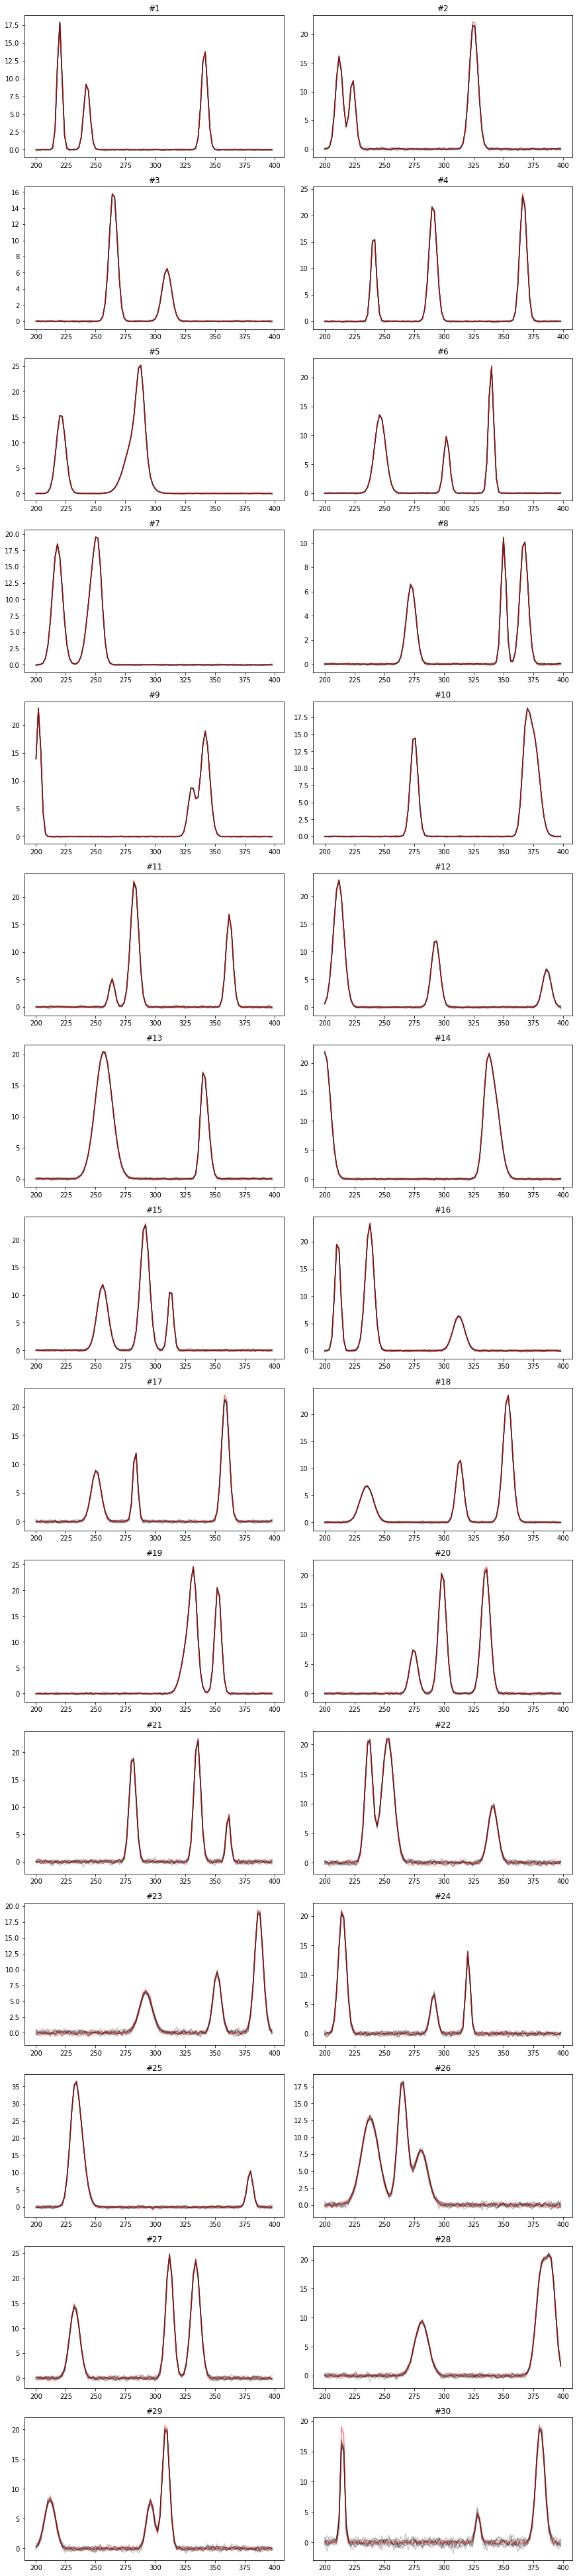

In [18]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(int(tsets/2),2), figure_size=(12,int(tsets*(1.8))),
                                    savefig='yes', fname=file_basename, showpeaks='no')

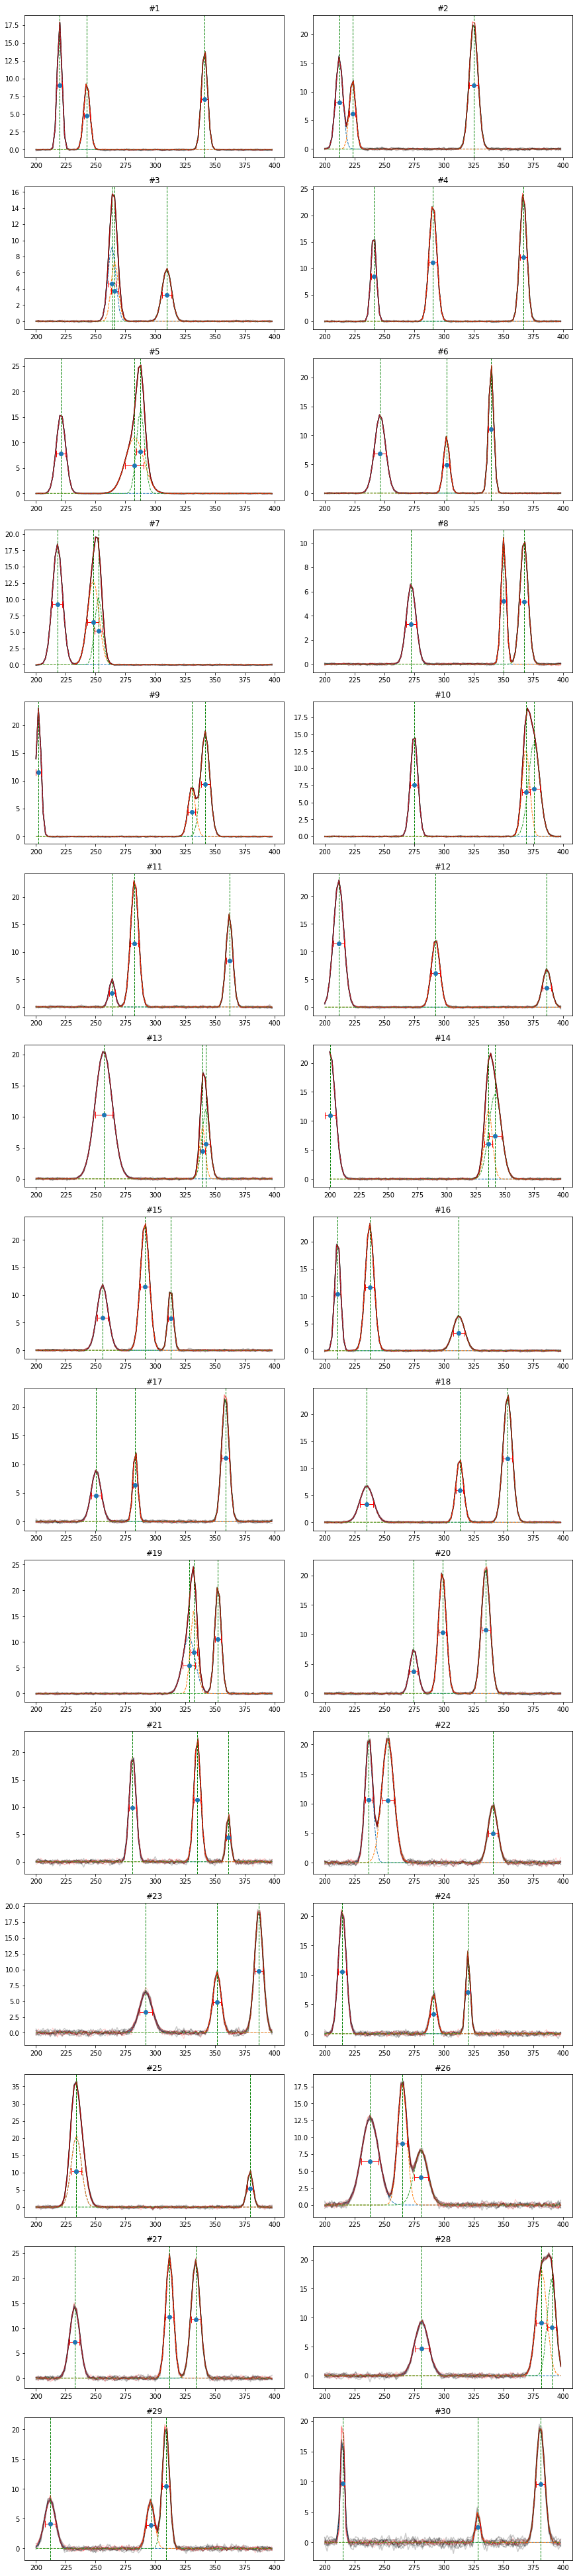

In [19]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(int(tsets/2),2), figure_size=(12,int(tsets*(1.8))),
                                    savefig='yes', fname=file_basename, showpeaks='yes')

In [20]:
cnf.close(out_path)